In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import os

# Check if a GPU is available for faster computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data paths for training and validation datasets
train_data_path = 'D:/image_seg/Dataset/Dataset/training'
val_data_path = 'D:/image_seg/Dataset/Dataset/validation'

# Define data augmentation and normalization for the training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.RandomRotation(20),  # Randomly rotate images by ±20 degrees
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, saturation, and hue
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Random affine transformations
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize validation images to 224x224 pixels
        transforms.CenterCrop(224),  # Center crop the validation images
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet means and stds
    ]),
}

# Load the datasets using ImageFolder for both training and validation
train_dataset = datasets.ImageFolder(train_data_path, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_data_path, transform=data_transforms['val'])

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained models (ResNet and DenseNet)
resnet = models.resnet50(weights='DEFAULT')  
densenet = models.densenet121(weights='DEFAULT')  

# Modify the final layers of the models to extract features instead of class predictions
num_ftrs_resnet = resnet.fc.in_features
resnet.fc = nn.Identity()  # Remove the final classification layer

num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Identity()  # Remove the final classification layer

# Define a combined model class that integrates features from both ResNet and DenseNet
class CombinedModel(nn.Module):
    def __init__(self, resnet, densenet, num_classes):
        super(CombinedModel, self).__init__()
        self.resnet = resnet
        self.densenet = densenet
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer for regularization
            nn.Linear(num_ftrs_resnet + num_ftrs_densenet, 512),  # Fully connected layer combining both model outputs
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(0.5),  # Dropout layer for regularization
            nn.Linear(512, num_classes)  # Final output layer for classification
        )

    def forward(self, x):
        resnet_out = self.resnet(x)  # Get features from ResNet
        densenet_out = self.densenet(x)  # Get features from DenseNet
        combined_out = torch.cat((resnet_out, densenet_out), dim=1)  # Concatenate the outputs
        return self.fc(combined_out)  # Pass concatenated features through the fully connected layers

# Instantiate the combined model with the specified number of classes
combined_model = CombinedModel(resnet, densenet, len(train_dataset.classes)).to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(combined_model.parameters(), lr=0.0001, weight_decay=1e-4)  # Adam optimizer with weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)  # Learning rate scheduler

# Initialize lists to store training and validation history
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Set the number of epochs for training
num_epochs = 50

# Create a directory to save plots if it doesn't exist
if not os.path.exists('plotsFinal'):
    os.makedirs('plotsFinal')


Using device: cuda


C:\Users\gautam\anaconda3\envs\gpu_mtl\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\gautam/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 42.0MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\gautam/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:01<00:00, 24.3MB/s]
C:\Users\gautam\anaconda3\envs\gpu_mtl\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
C:\Users\gautam\anaconda3\envs\gpu_mtl\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descr

Epoch 1/50, Train Loss: 0.8199, Train Accuracy: 0.7715, Val Loss: 0.5397, Val Accuracy: 0.8285
Epoch 2/50, Train Loss: 0.6421, Train Accuracy: 0.8074, Val Loss: 0.4156, Val Accuracy: 0.8721
Epoch 3/50, Train Loss: 0.5669, Train Accuracy: 0.8276, Val Loss: 0.3758, Val Accuracy: 0.8835
Epoch 4/50, Train Loss: 0.5194, Train Accuracy: 0.8403, Val Loss: 0.3695, Val Accuracy: 0.8866
Epoch 5/50, Train Loss: 0.4899, Train Accuracy: 0.8481, Val Loss: 0.3459, Val Accuracy: 0.8960
Epoch 6/50, Train Loss: 0.4634, Train Accuracy: 0.8563, Val Loss: 0.3052, Val Accuracy: 0.9072
Epoch 7/50, Train Loss: 0.4479, Train Accuracy: 0.8612, Val Loss: 0.2944, Val Accuracy: 0.9079
Epoch 8/50, Train Loss: 0.4302, Train Accuracy: 0.8659, Val Loss: 0.2567, Val Accuracy: 0.9163
Epoch 9/50, Train Loss: 0.4192, Train Accuracy: 0.8682, Val Loss: 0.2748, Val Accuracy: 0.9133
Epoch 10/50, Train Loss: 0.4049, Train Accuracy: 0.8725, Val Loss: 0.2688, Val Accuracy: 0.9156
Epoch 11/50, Train Loss: 0.4034, Train Accuracy: 

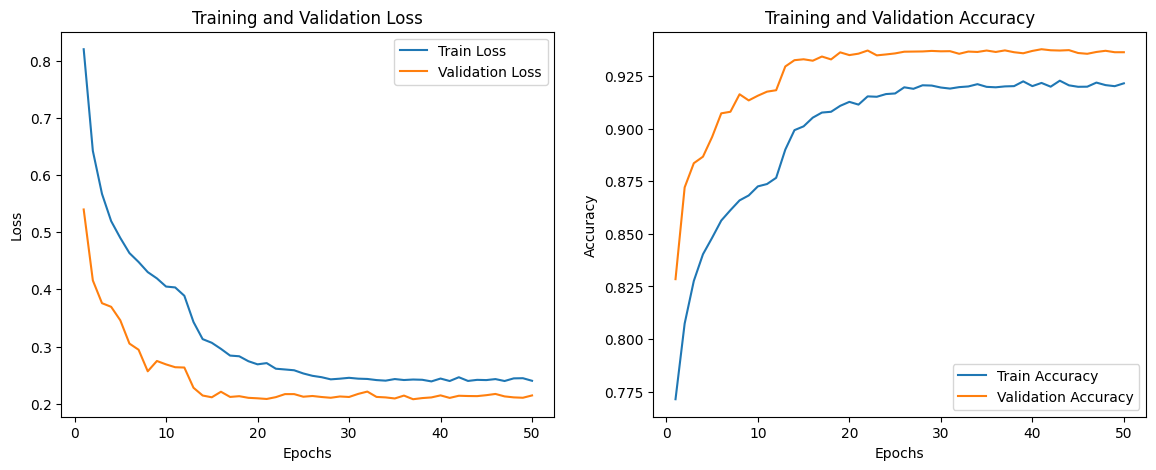

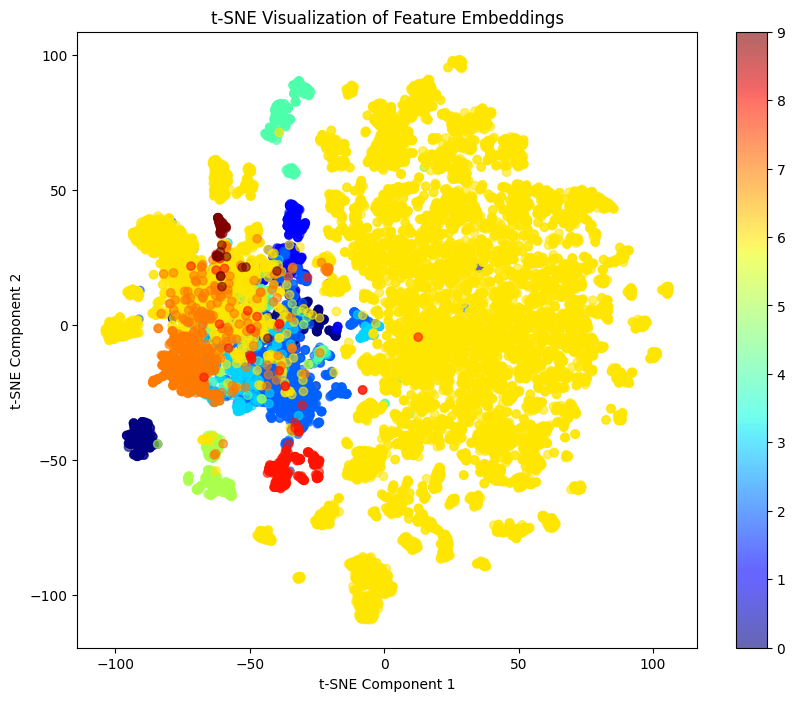

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

In [2]:

# Train and validate the combined model
for epoch in range(num_epochs):
    combined_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = combined_model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss
        _, preds = torch.max(outputs, 1)  # Get predictions
        correct += (preds == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total examples
    
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_loss_history.append(epoch_loss)  # Store training loss
    train_acc_history.append(epoch_acc)  # Store training accuracy

    # Validation phase
    combined_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device
            outputs = combined_model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            val_loss += loss.item()  # Accumulate validation loss
            _, preds = torch.max(outputs, 1)  # Get predictions
            val_correct += (preds == labels).sum().item()  # Count correct predictions
            val_total += labels.size(0)  # Count total examples
    
    # Calculate average validation loss and accuracy for the epoch
    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total
    val_loss_history.append(val_epoch_loss)  # Store validation loss
    val_acc_history.append(val_epoch_acc)  # Store validation accuracy

    # Print epoch metrics to track training progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.4f}')
    
    # Step the scheduler based on validation loss
    scheduler.step(val_epoch_loss)

# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('plotsFinal/training_validation_loss.png')  # Save the loss plot

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('plotsFinal/training_validation_accuracy.png')  # Save the accuracy plot
plt.show()

# Confusion matrix and ROC curve generation
combined_model.eval()  # Set model to evaluation mode
all_labels = []  # List to store all true labels
all_preds = []  # List to store all predictions
all_probs = []  # List to store all predicted probabilities
all_features = []  # List to store all features

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device
        outputs = combined_model(inputs)  # Forward pass to get outputs
        features = torch.cat((resnet(inputs), densenet(inputs)), dim=1)  # Get features from both models
        _, preds = torch.max(outputs, 1)  # Get predictions
        probs = nn.functional.softmax(outputs, dim=1)  # Calculate predicted probabilities
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_preds.extend(preds.cpu().numpy())  # Store predictions
        all_probs.extend(probs.cpu().numpy())  # Store predicted probabilities
        all_features.append(features.cpu().numpy())  # Store features

# Convert features to a numpy array for further analysis
all_features = np.concatenate(all_features)

# t-SNE Visualization for feature embeddings
tsne = TSNE(n_components=2, random_state=42)  # Initialize t-SNE
features_tsne = tsne.fit_transform(all_features)  # Fit and transform the features

# Plotting t-SNE for visualizing feature embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=all_labels, cmap='jet', alpha=0.6)
plt.colorbar(scatter, ticks=range(len(train_dataset.classes)))  # Add color bar for classes
plt.title('t-SNE Visualization of Feature Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig('plotsFinal/tsne_visualization.png')  # Save the t-SNE plot
plt.show()

# Generate confusion matrix to evaluate model performance
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('plotsFinal/confusion_matrix.png')  # Save the confusion matrix plot
plt.show()

# Print classification report to see detailed metrics
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# ROC Curve generation for multi-class classification
all_labels_bin = label_binarize(all_labels, classes=range(len(train_dataset.classes)))  # Binarize the labels for ROC
fpr = dict()  # Dictionary to store false positive rates
tpr = dict()  # Dictionary to store true positive rates
roc_auc = dict()  # Dictionary to store AUC values

# Calculate ROC curve and AUC for each class
for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curve for multi-class classification
plt.figure(figsize=(10, 8))
for i in range(len(train_dataset.classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {train_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for chance level
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('plotsFinal/roc_curve.png')  # Save the ROC curve plot
plt.show()

# Save the trained model for future use
torch.save(combined_model.state_dict(), 'D:/image_seg/Dataset/Dataset/combined_model.pth')


In [3]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score
import json
import torch

def save_predictions_to_excel(image_paths, y_pred, output_path):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    
    df_merged.to_excel(output_path, index=False)

def calculate_specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

def generate_metrics_report(y_true, y_pred):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}

    # Convert to numpy if tensors
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()
    if torch.is_tensor(y_pred):
        y_pred = y_pred.cpu().numpy()

    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Classification Report
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)

    # AUC-ROC Scores
    auc_roc_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            auc_roc_scores[class_name] = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            auc_roc_scores[class_name] = 0.0  

    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    auc_roc_scores['mean_auc'] = mean_auc_roc

    # Specificity Scores
    specificity_scores = {}
    for i, class_name in enumerate(class_columns):
        specificity_scores[class_name] = calculate_specificity(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int))
    
    mean_specificity = np.mean(list(specificity_scores.values()))
    specificity_scores['mean_specificity'] = mean_specificity

    # Average Precision Scores
    average_precision_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            average_precision_scores[class_name] = auc(recall, precision)
        except ValueError:
            average_precision_scores[class_name] = 0.0  
    
    mean_average_precision = np.mean(list(average_precision_scores.values()))
    average_precision_scores['mean_average_precision'] = mean_average_precision

    # Sensitivity Scores (Recall)
    sensitivity_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            sensitivity_scores[class_name] = recall_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            sensitivity_scores[class_name] = 0.0  
    
    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    sensitivity_scores['mean_sensitivity'] = mean_sensitivity

    # F1 Scores
    f1_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            f1_scores[class_name] = f1_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            f1_scores[class_name] = 0.0  
    
    mean_f1_score = np.mean(list(f1_scores.values()))
    f1_scores['mean_f1_score'] = mean_f1_score

    # Balanced Accuracy Score
    balanced_accuracy_scores = balanced_accuracy_score(y_true_classes, y_pred_classes)

    # Aggregating all metrics
    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy_scores

    # Convert the metrics report to JSON format
    metrics_report_json = json.dumps(metrics_report, indent=4)
    return metrics_report_json


In [6]:
!pip install openpyxl

   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.9 kB ? eta -:--:--
   ----------- ---------------------------- 71.7/250.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 250.9/250.9 kB 3.1 MB/s eta 0:00:00


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image
import platform

# Load the model
model_path = os.path.join(os.getcwd(), 'D:/image_seg/combined_model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedModel(resnet, densenet, len(train_dataset.classes))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Data preprocessing function (adjust based on your model requirements)
def load_and_preprocess_image(full_path, image_size=(32, 32)):
    img = Image.open(full_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-style normalization
    ])
    img = transform(img)
    return img

# Custom dataset class for validation data
#class CustomDataset(Dataset):
 #   def __init__(self, df, base_dir, image_size=(32, 32)):
  #      self.df = df
   #     self.base_dir = base_dir
    #    self.image_size = image_size
    #    self.class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

    #def __len__(self):
     #   return len(self.df)

    #def __getitem__(self, idx):
     #   img_path = os.path.join(self.base_dir, self.df.iloc[idx]['image_path'])
      #  image = load_and_preprocess_image(img_path, self.image_size)
      #  label = torch.tensor(self.df.iloc[idx][self.class_columns].values, dtype=torch.float32)
      #  return image, label
# Custom dataset class for validation data
class CustomDataset(Dataset):
    def __init__(self, df, base_dir, image_size=(32, 32)):
        self.df = df
        self.base_dir = base_dir
        self.image_size = image_size
        self.class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.df.iloc[idx]['image_path'])
        image = load_and_preprocess_image(img_path, self.image_size)
        
        # Fixing the label processing issue here
        # Convert class columns to numeric and fill NaN with 0
        label = self.df.iloc[idx][self.class_columns].apply(pd.to_numeric, errors='coerce').fillna(0).values
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label

# Loading the data from Excel
def get_data(excel_path, base_dir, image_size=(32, 32)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    if platform.system() == 'Windows':
        df['image_path'] = df['image_path'].apply(lambda x: x.replace('/', os.sep))
    else:
        df['image_path'] = df['image_path'].apply(lambda x: x.replace('\\', os.sep))
    dataset = CustomDataset(df, base_dir, image_size)
    return dataset, df

# Data loading
base_dir = os.path.join(os.getcwd(), 'D:/image_seg/Dataset/Dataset/')
val_excel_path = os.path.join(os.getcwd(), 'D:/image_seg/Dataset/Dataset/validation/validation_data.xlsx')
image_size = (32, 32)
val_dataset, val_df = get_data(val_excel_path, base_dir=base_dir, image_size=image_size)

# DataLoader for batch processing
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Perform predictions
y_val_pred = []
y_val_true = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        y_val_pred.append(outputs.cpu().numpy())
        y_val_true.append(labels.cpu().numpy())

y_val_pred = np.vstack(y_val_pred)
y_val_true = np.vstack(y_val_true)

# Example of generating metrics (you can adapt this based on your metrics generation logic)
def generate_metrics_report(y_true, y_pred):
    # Placeholder: implement your metric generation logic here
    # This could include accuracy, precision, recall, F1, etc.
    metrics_df = pd.DataFrame({"Metric": ["Placeholder"], "Value": [0]})  # Replace with real metrics
    return metrics_df

df = generate_metrics_report(y_val_true, y_val_pred)
print(df)

# Save predictions to Excel
def save_predictions_to_excel(image_paths, predictions, output_file):
    df = pd.DataFrame({'Image_Path': image_paths})
    pred_df = pd.DataFrame(predictions, columns=['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms'])
    output_df = pd.concat([df, pred_df], axis=1)
    output_df.to_excel(output_file, index=False)

output_val_predictions = "validation_excel.xlsx"
save_predictions_to_excel(val_df['image_path'].values, y_val_pred, output_val_predictions)



        Metric  Value
0  Placeholder      0


In [11]:
# For Test data - uncomment when you have test data

#test_path = os.path.join(os.getcwd(), 'D:/image_seg/Testing set/Testing set/Images/')  # replace with path of your test data
#test_image_filenames = [fname for fname in os.listdir(test_path) if fname.lower().endswith(('jpg'))]
#test_images = [load_and_preprocess_image(os.path.join(test_path, fname), image_size=image_size) for fname in test_image_filenames]
#test_images = torch.stack(test_images)
#test_images = test_images.to(device)

#y_test_pred = model(test_images)
#y_test_pred = y_test_pred.cpu().numpy()

#output_test_predictions = "test_excel.xlsx"
#save_predictions_to_excel(test_image_filenames, y_test_pred, output_test_predictions)



RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [12]:
test_path = os.path.join(os.getcwd(), 'D:/image_seg/Testing set/Testing set/Images/')  # replace with path of your test data
test_image_filenames = [fname for fname in os.listdir(test_path) if fname.lower().endswith(('jpg'))]

# Preprocess all test images
test_images = [load_and_preprocess_image(os.path.join(test_path, fname), image_size=image_size) for fname in test_image_filenames]

# Stack and move to device (GPU/CPU)
test_images = torch.stack(test_images)
test_images = test_images.to(device)

# Perform prediction (no gradients required here, so we use torch.no_grad)
with torch.no_grad():
    y_test_pred = model(test_images)

# Detach and convert predictions to numpy
y_test_pred = y_test_pred.detach().cpu().numpy()

# Save predictions to an Excel file
output_test_predictions = "test_excel.xlsx"
save_predictions_to_excel(test_image_filenames, y_test_pred, output_test_predictions)
